In [2]:
%load_ext autoreload
%autoreload 2
%cd '/home/xingyu/Projects/PlasticineLab'
%pwd
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from plb.envs import make
from imitation.train_full import get_args
from imitation.env_spec import set_render_mode
from plb.engine.taichi_env import TaichiEnv
from plb.optimizer.solver import Solver
from plb.algorithms.logger import Logger

device = 'cuda'

log_dir = './data/connect'
args = get_args("")

obs_channel = len(args.img_mode)
img_obs_shape = (args.image_dim, args.image_dim, obs_channel)

args.env_name ='GatherMove-v1'
# args.cached_state_path = './datasets/0923_GatherMove'
env = make(args.env_name)
set_render_mode(env, args.env_name, 'mesh')
env.seed(args.seed)
taichi_env: TaichiEnv = env.unwrapped.taichi_env
T = env._max_episode_steps
solver = Solver(args, taichi_env, (0,), return_dist=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/xingyu/Projects/PlasticineLab
[Tina] version 0.1.1
pimirives: num primitive: 3
Building primitive
action:
  dim: 7
  scale: (0.015, 0.0, 0.015, 0.0, 0.0, 0.1, 0.03)
collision_group: [0.0, 0.0, 0.0]
color: (0.7568, 0.6039, 0.4196)
friction: 1.0
init_gap: 0.4
init_pos: (0.7, 0.06, 0.5)
init_rot: (0.5, 0.5, -0.5, 0.5)
lower_bound: (0.0, 0.0, 0.0)
maximal_gap: 1.0
minimal_gap: 0.05
round: 0
shape: Gripper
size: (0.015, 0.09, 0.05)
upper_bound: (1.0, 1.0, 1.0)
variations: None
Building primitive
action:
  dim: 6
  scale: (0.01, 0.01, 0.0, 0.0, 0.0, 0.05)
collision_group: [0, 0, 1]
color: (0.7568, 0.6039, 0.4196)
friction: 50.0
init_pos: (0.7, 0.01, 0.5)
init_rot: (0.707, 0.707, 0.0, 0.0)
lower_bound: (0.0, 0.0, 0.0)
shape: Box
size: (0.07, 0.07, 0.02)
upper_bound: (1.0, 1.0, 1.0)
variations: None
Building primitive
action:
  dim: 0
  scale: ()
collision_group: [0.0, 0.0, 0.0]
color: (0.5, 0.5, 0.5)

In [ ]:
from imitation.utils import to_action_mask
import matplotlib.pyplot as plt
from imitation.sampler import sample_traj
from imitation.utils import to_action_mask
import numpy as np
from plb.utils.visualization_utils import save_numpy_as_gif

args.lr = 0.02 # Larger lr (0.1) seems to give pretty good performance (in 30 iterations for 0.1)
args.gd_max_iter = 200
args.num_env = 1 

# r_key1 = {'init_v':0 , 'target_v': 1, 'contact_loss_mask': [1, 0, 0]}
# r_key2 = {'init_v':1, 'target_v':1, 'contact_loss_mask': [1, 0, 0]}
r_key3 = {'init_v':1, 'target_v':10, 'contact_loss_mask': [0, 0, 0]}
tid = 0
trajs = []
for i, r_key in enumerate([r_key3]):
    filename = 'data/env_modeling/solve_gather_{}.gif'.format(i)
    traj = sample_traj(env, solver, r_key, tid, action_mask=to_action_mask(env, 1), reset_primitive=False)
    trajs.append(traj)
    
    save_numpy_as_gif(np.array(traj['obses']) * 255, filename)

    from IPython.display import Image
    Image(filename)

In [9]:
from imitation.imitation_buffer import ImitationReplayBuffer
from imitation.train_full import get_args
args = get_args()
buffer = ImitationReplayBuffer(args)
# buffer.load('data/autobot/0829_PushSpread/0829_PushSpread/')
buffer.load('data/seuss/0926_GatherMove_vel_loss/0926_GatherMove_vel_loss/0926_GatherMove_vel_loss_2021_09_26_17_28_11_0002/dataset.gz')
buffer_actions = buffer.buffer['actions'][0: 50]
solver.load_buffer()
solved_action = solver._buffer[120]['action']

Loading dataset in data/seuss/0926_GatherMove_vel_loss/0926_GatherMove_vel_loss/0926_GatherMove_vel_loss_2021_09_26_17_28_11_0002/dataset.gz
Loading dataset from data/seuss/0926_GatherMove_vel_loss/0926_GatherMove_vel_loss/0926_GatherMove_vel_loss_2021_09_26_17_28_11_0002/dataset.gz


Env reseting to: datasets/0926_GatherMove/target/target_10.npy, init v: 0, target v: 10
emd after reset: 0.307087779045105
reset primitive in 42 steps
MoviePy - Building file data/env_modeling/gather_test.gif with imageio.


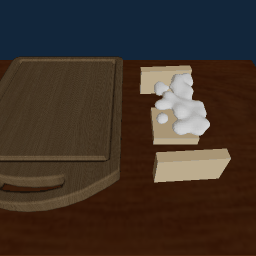

In [10]:
import numpy as np
from plb.utils.visualization_utils import save_numpy_as_gif
np.set_printoptions(precision=3, suppress=True)
r_key = {'init_v':0 , 'target_v': 10, 'contact_loss_mask': [0, 0, 0]}
imgs = []
set_render_mode(env, 'GatherMove-v1', 'mesh')
env.reset(**r_key)
primitive_state = env.get_primitive_state()
for action in buffer_actions:
    env.step(action)
    img = env.taichi_env.render(mode='rgb', img_size=256)
    imgs.append(img)

reset_actions, reset_obses, _, _ = env.primitive_reset_to(idx=tid, reset_states=primitive_state, img_size=256)
for obs in reset_obses:
    imgs.append(obs)

for action in solved_action:
    env.step(action)
    img = env.taichi_env.render(mode='rgb', img_size=256)
    imgs.append(img)                
f = 'data/env_modeling/gather_test.gif'
save_numpy_as_gif(np.array(imgs) * 255, f)
from IPython.display import Image
Image(f)

In [2]:
# Generate a lift video
from plb.utils.visualization_utils import save_numpy_as_gif
import numpy as np
filename = 'data/env_modeling/gather_combined.gif'
env.reset(init_v=106, target_v=36)
reset_states = env.get_primitive_state()
a1, a2 = trajs[0]['actions'], trajs[1]['actions']
img_size= 256

frames = []
for i in range(len(a1)):
    env.step(a1[i])
    frames.append(env.taichi_env.render(mode='rgb', img_size=img_size)[:,:,:3])
actions, obses, _ = env.primitive_reset_to(1, reset_states, img_size=img_size)
for frame in obses:
    frames.append(frame[:, :, :3])
for i in range(len(a2)):
    action = np.array([0]* 6 + [-0.7, 0.8, 0., 0., 0., 0.7])
    env.step(a2[i])
    frames.append(env.taichi_env.render(mode='rgb', img_size=img_size)[:,:,:3])
# actions, obses, _ = env.primitive_reset_to(0, reset_states, img_size=img_size)
# for frame in obses:
#     frames.append(frame[:, :, :3])
save_numpy_as_gif(np.array(frames), filename)
demo_actions = np.array(actions)
state = env.get_state()
from IPython.display import Image
Image(filename)

{'init_pos': (0.65, 0.08, 0.5), 'radius': 0.05, 'color': 100}
Env reseting to:  /home/xingyu/Projects/PlasticineLab/plb/envs/../../datasets/0914_LiftSpread/target/target_36.npy
emd after reset: 0.30352258682250977
======================WARNING: contact loss mask not set================


NameError: name 'trajs' is not defined

In [4]:
# Debug actions from replay buffer
dataset_path = 'data/local/0915_LiftSpread_single/0915_LiftSpread_single_2021_09_15_21_14_53_0001/dataset.gz'
from imitation.imitation_buffer import ImitationReplayBuffer
buffer = ImitationReplayBuffer(args)
buffer.load(dataset_path)

Loading dataset in data/local/0915_LiftSpread_single/0915_LiftSpread_single_2021_09_15_21_14_53_0001/dataset.gz
Loading dataset from data/local/0915_LiftSpread_single/0915_LiftSpread_single_2021_09_15_21_14_53_0001/dataset.gz
(50, 12)


{'init_pos': (0.65, 0.08, 0.5), 'radius': 0.05, 'color': 100}
Env reseting to:  /home/xingyu/Projects/PlasticineLab/plb/envs/../../datasets/0914_LiftSpread/target/target_36.npy
emd after reset: 0.30352258682250977
======================WARNING: contact loss mask not set================
step 0, reward: -0.3028736412525177, emd: 0.3028736412525177, contact_loss: 0.0
step 1, reward: -0.30077075958251953, emd: 0.30077075958251953, contact_loss: 0.0
step 2, reward: -0.2966059446334839, emd: 0.2966059446334839, contact_loss: 0.0
step 3, reward: -0.29008060693740845, emd: 0.29008060693740845, contact_loss: 0.0
step 4, reward: -0.2825418710708618, emd: 0.2825418710708618, contact_loss: 0.0
step 5, reward: -0.2749570310115814, emd: 0.2749570310115814, contact_loss: 0.0
step 6, reward: -0.26736244559288025, emd: 0.26736244559288025, contact_loss: 0.0
step 7, reward: -0.26005426049232483, emd: 0.26005426049232483, contact_loss: 0.0
step 8, reward: -0.25294315814971924, emd: 0.25294315814971924, c

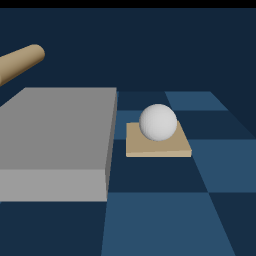

In [9]:
# Generate a lift video
from plb.utils.visualization_utils import save_numpy_as_gif
import numpy as np
filename = 'debug.gif'
env.reset(init_v=106, target_v=36)
reset_states = env.get_primitive_state()
img_size= 256
frames = []
actions = buffer.buffer['actions'][:50]
infos = []
for s, action in enumerate(actions):
    obs, r, _, info = env.step(action)
    infos.append(info)
    print('step {}, reward: {}, emd: {}, contact_loss: {}'.format(s, r, info['info_emd'], info['info_contact_loss']))
    frames.append(env.taichi_env.render(mode='rgb', img_size=img_size)[:,:,:3])
emds = np.array([info['info_emd'] for info in infos])
print('emds:', emds)
save_numpy_as_gif(np.array(frames), filename)
demo_actions = np.array(actions)
state = env.get_state()
from IPython.display import Image
Image(filename)